In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, execute, Aer, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.compiler import assemble

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Importing other required libraries
import networkx as nx
from scipy.optimize import minimize
import sys
from numpy import pi

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

### Creating a 5-node graph

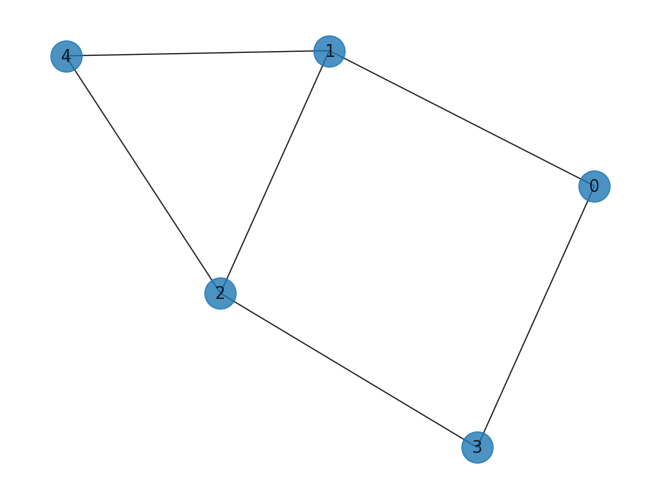

In [22]:
# Creating a grpah with 5 nodes
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), [1, 4], [2, 4]])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

### Creating the Intital State

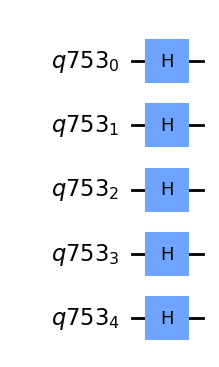

In [23]:
# Creating a quantum circuit for 5 qubits and applying hadamard gates to each
n_qb = 5
qubit = QuantumRegister(n_qb)

qc = QuantumCircuit(qubit)
qc.h(qubit)

qc.draw()

### Creating the Cost hamiltonian
Applying the unitary U(γ) corresponding to the problem Hamiltonian U(γ) = exp(−iγH_p )

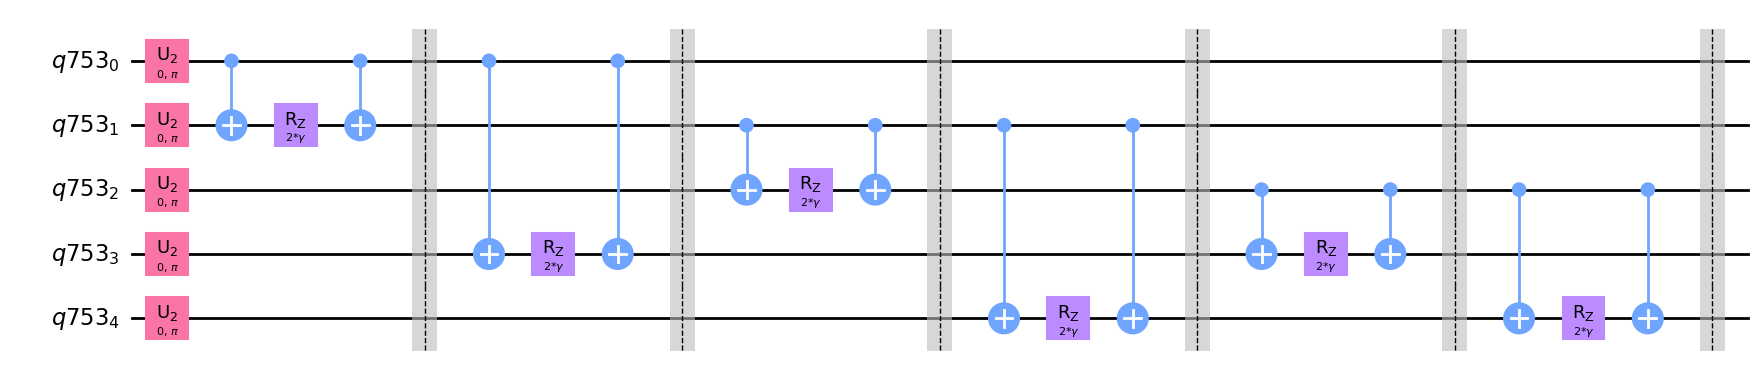

In [24]:
#Creating cost hamiltonian
from qiskit.circuit import Parameter

gamma = Parameter("$\\gamma$")
for pair in list(G.edges()):
    qc.rzz(2 * gamma, pair[0], pair[1])
    qc.barrier()

qc.decompose().draw()

### Creating the Mixer hamiltonian 
Applying the unitary U(β) corresponding to the problem Hamiltonia U(β) = exp(−iβH_m)

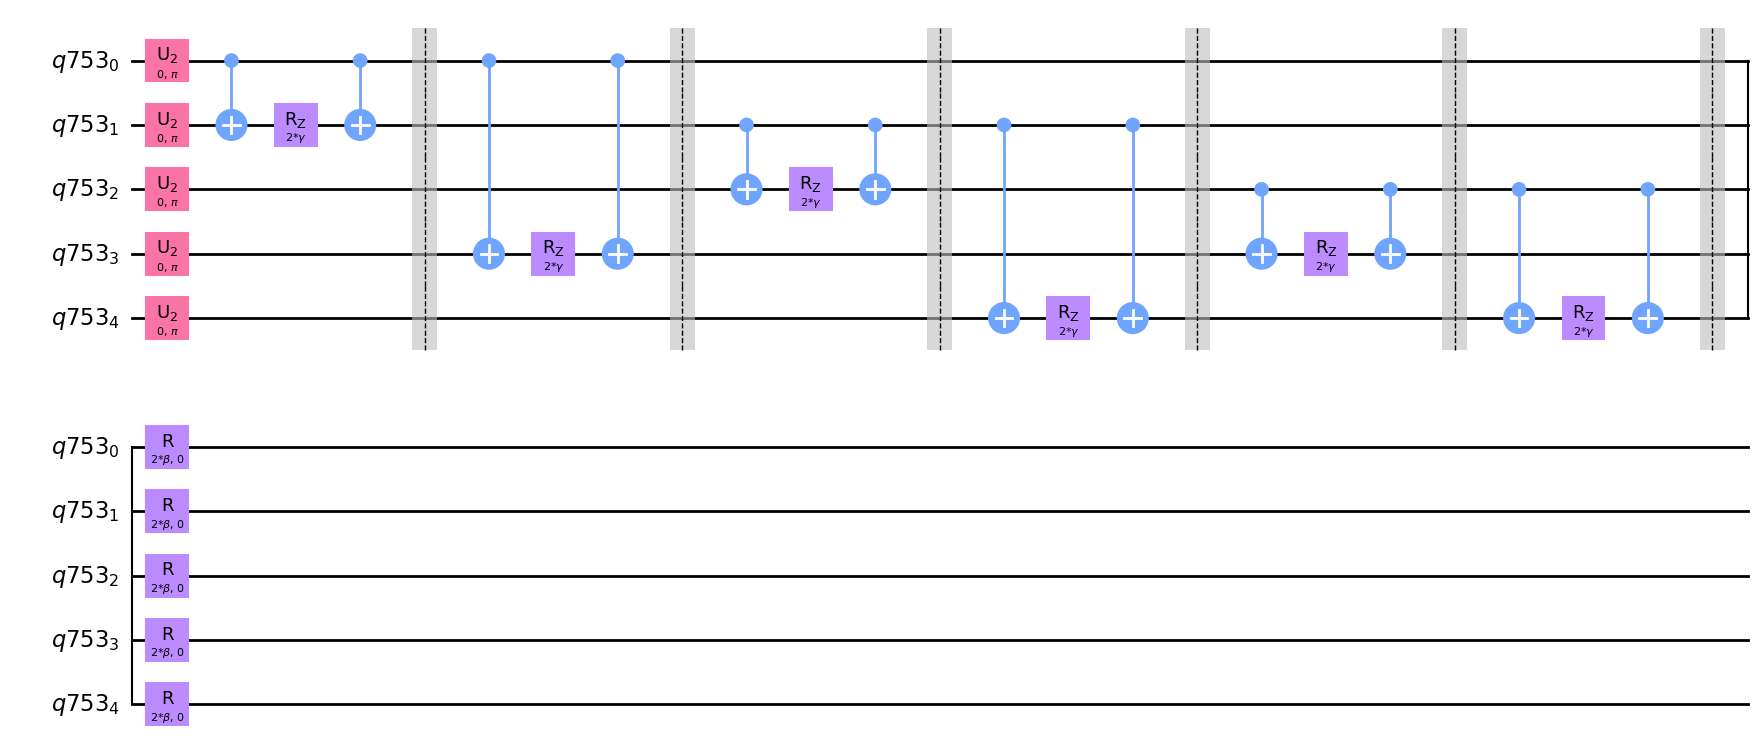

In [25]:
#Creating mixer hamiltonian
beta = Parameter("$\\beta$")
for i in range(0, n_qb):
    qc.rx(2 * beta, i)
    
qc.decompose().draw()

In [32]:
def expectation(theta):
    """
    Computes expectation value based on 
    measurement results
    """
    cost = 0
    cummulative = 0
    sum_count = 0

    backend = Aer.get_backend('qasm_simulator')
    pqc = create_qaoa_circ(G, theta)
    result = execute(pqc, backend, shots=1024).result().get_counts()

    for bitstring, count in result.items():
        for i, j in G.edges():
            if bitstring[i] != bitstring[j]:
                cost -= 1
        cummulative += cost * count
        sum_count += count

    return cummulative/sum_count

In [33]:
def create_qaoa_circ(G,theta):
    """
    Creates a parametrized qaoa circuit
    """
    nqubits = len(G.nodes())
    qc_qaoa = QuantumCircuit(n_qb)

    # initial_state
    qc.h(range(nqubits))

    for irep in range(0, len(theta)):

        # problem unitary
        for pair in list(G.edges()):
            qc_qaoa.rzz(2 * theta[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc_qaoa.rx(2 * theta[irep], i)
        
        if irep != len(theta) - 1:
            qc_qaoa.barrier()

    qc_qaoa.measure_all()

    return qc_qaoa

### Testing for p = 5 iterations

In [34]:
# for 5 repititions, i.e p = 5
res = minimize(lambda x: expectation(x), [1., 1., 1., 1., 1.], method='COBYLA')
print (res)

     fun: -44.5966796875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 53
  status: 1
 success: True
       x: array([1.4842001 , 2.05465447, 0.97301953, 0.92556105, 0.92019304])


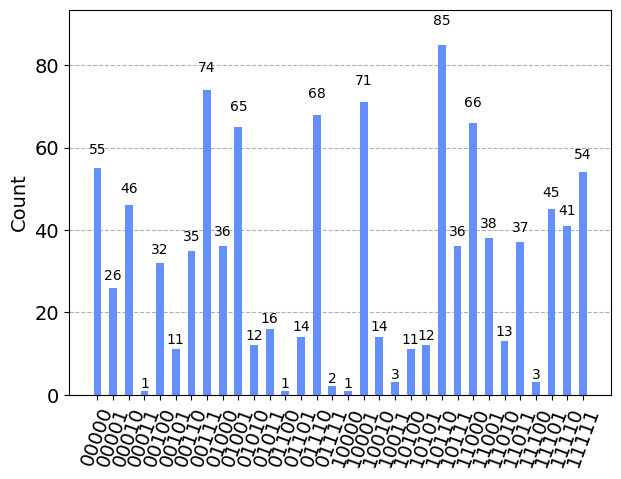

In [30]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 1000

from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

### QAOA Circuit for p =5

In [44]:
circuit_5_iter = create_qaoa_circ(G,res.x)

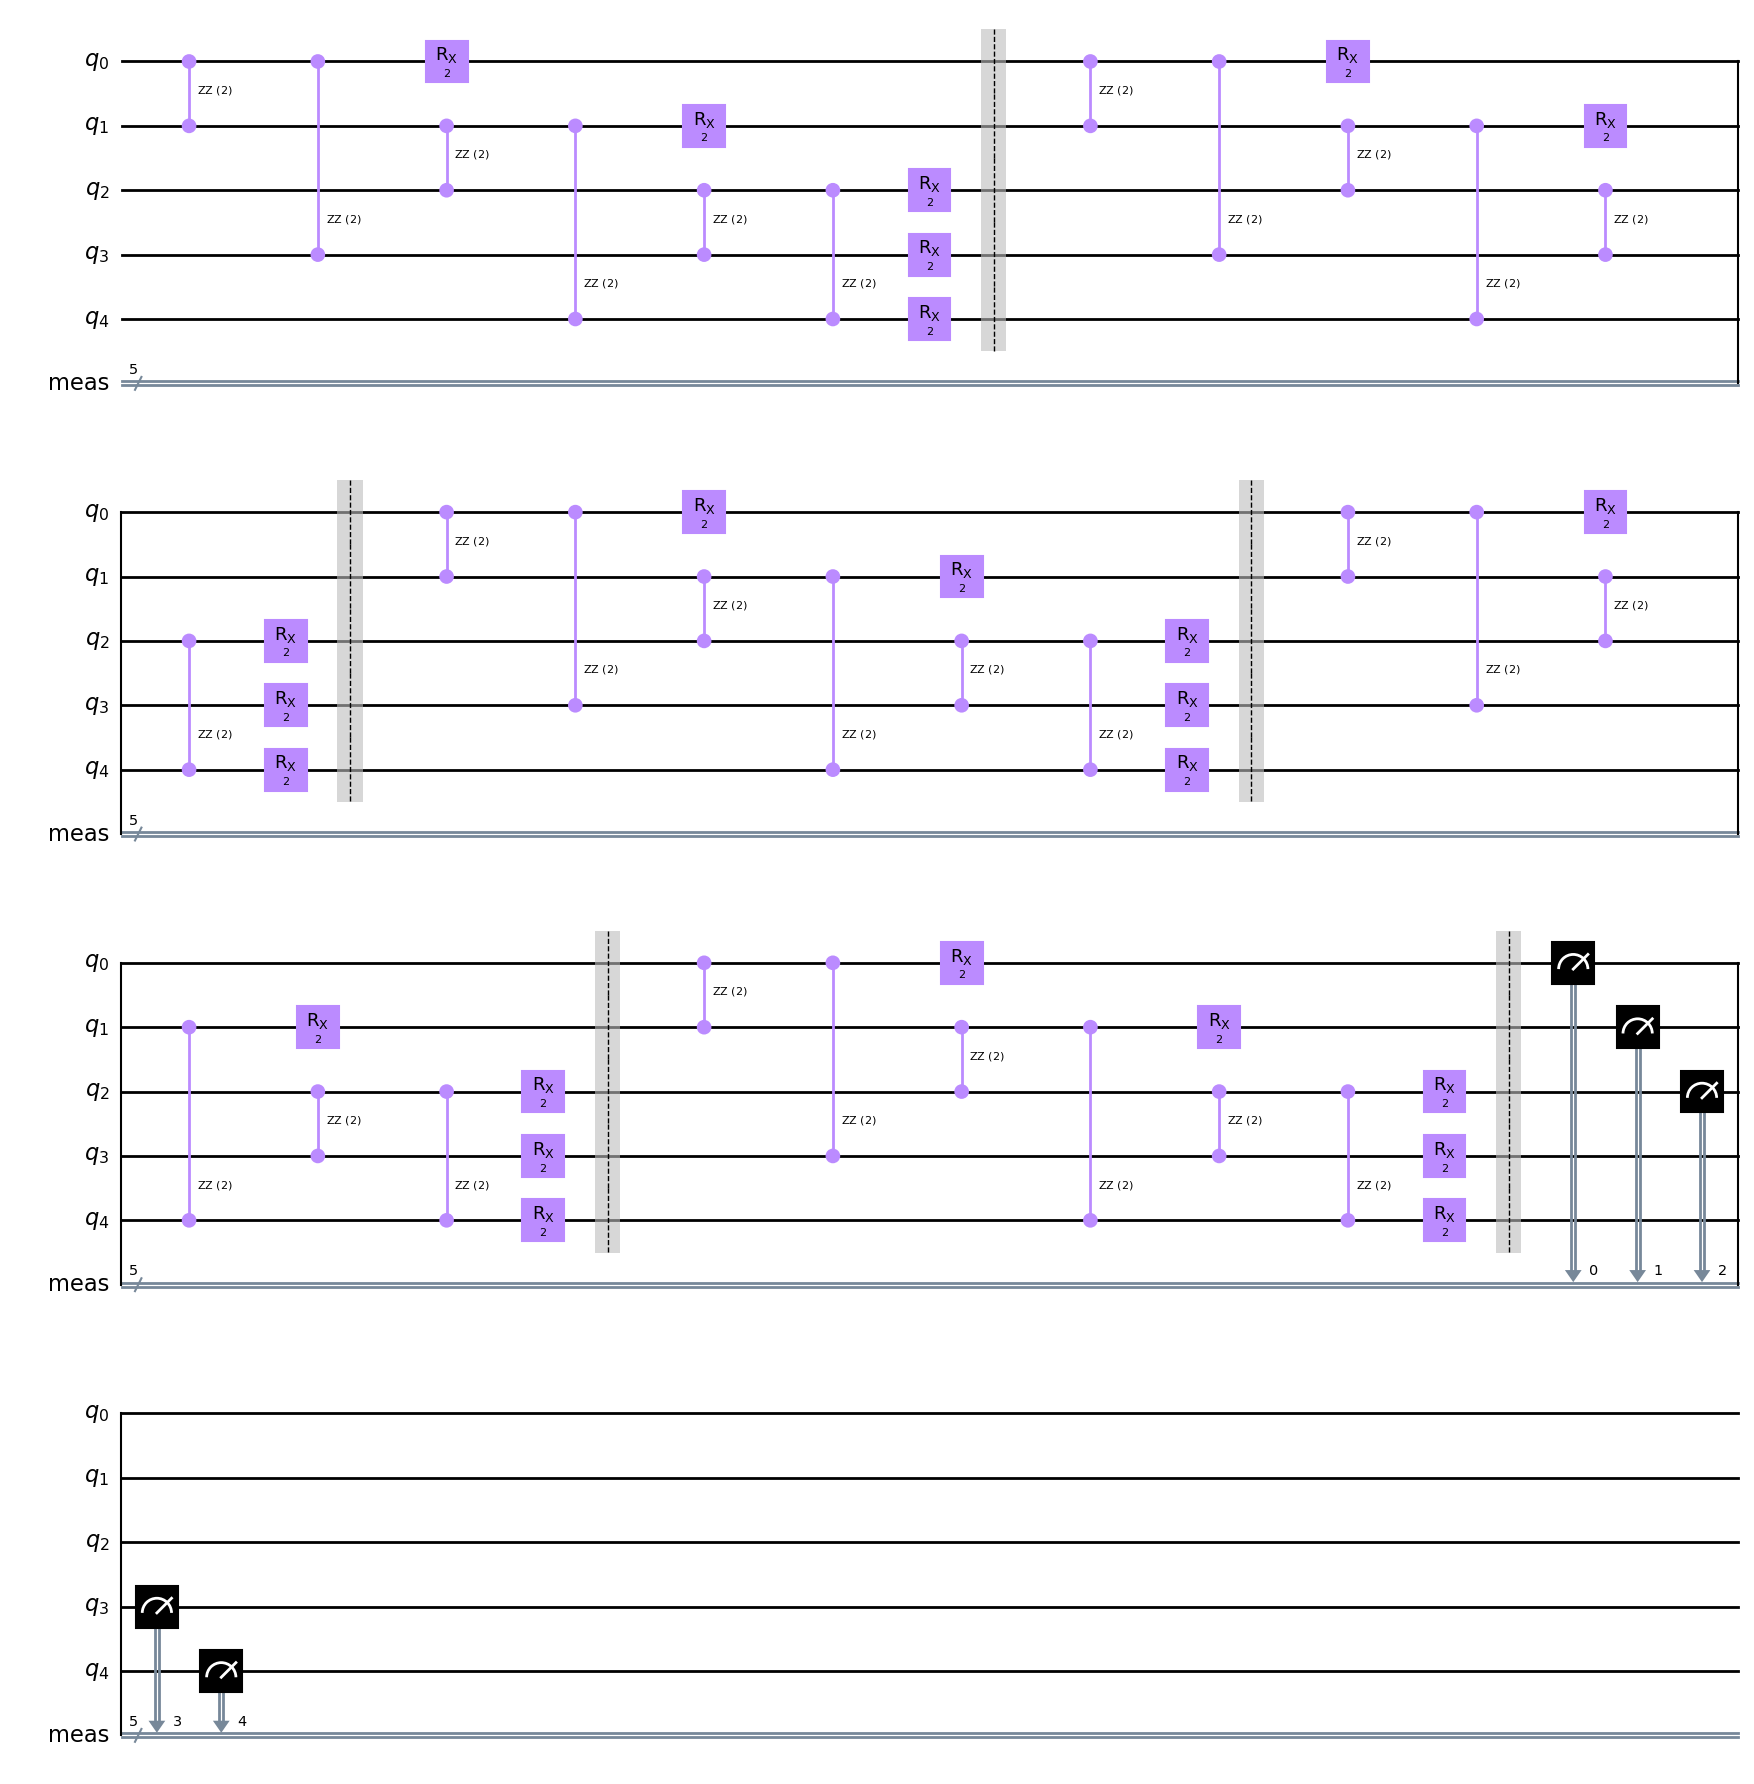

In [45]:
circuit_5_iter.draw()

### Testing for p = 2

In [49]:
# for 5 repititions, i.e p = 2
res = minimize(lambda x: expectation(x), [1., 1.], method='COBYLA')
print (res)

     fun: -38.5400390625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 25
  status: 1
 success: True
       x: array([1.00000447, 1.9999001 ])


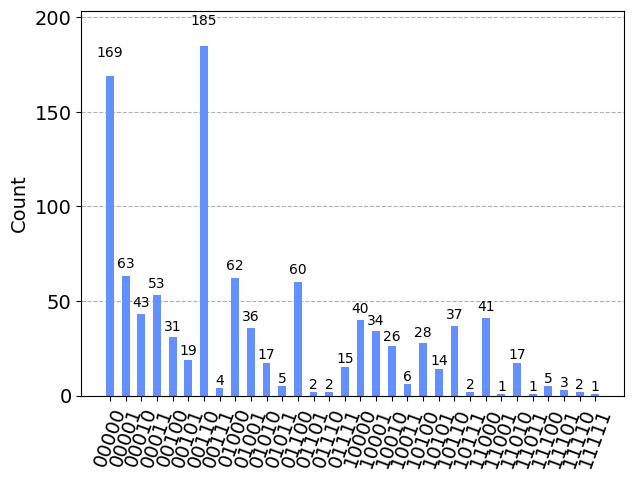

In [50]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 1000

from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

### QAOA Circuit for p = 2

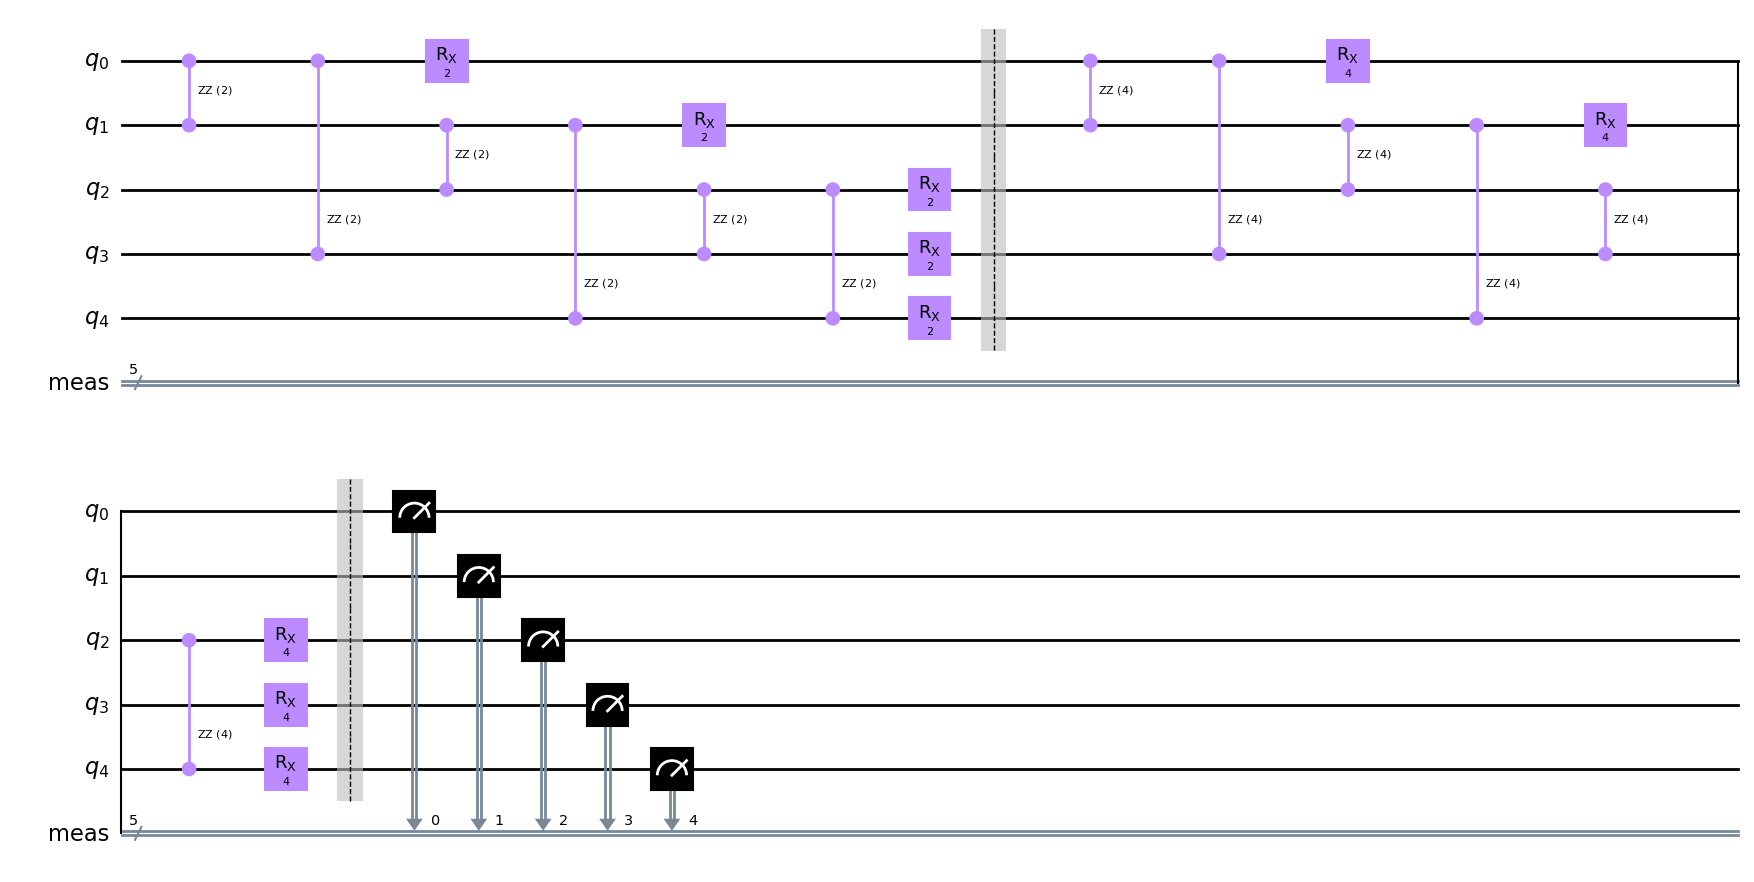

In [51]:
circuit_2_iter = create_qaoa_circ(G,res.x)
circuit_2_iter.draw()

#### References:

    1. https://learn.qiskit.org/course/ch-applications/solving-combinatorial-optimization-problems-using-qaoa
    
    2. https://github.com/Pratha-Me/QAOA-Max-Cut/tree/main
    
    3. https://arxiv.org/abs/1411.4028
    
    4. https://quantumai.google/cirq/experiments/qaoa/qaoa_maxcut
    